In [461]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [462]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D

In [463]:
"""
Returns the tau's to be predicted
"""
def get_output_data():
    tau_11 = loadmat('tau11_xyz_T1.mat')['tau11']
    tau_12 = loadmat('tau12_xyz_T1.mat')['tau12']
    tau_13 = loadmat('tau13_xyz_T1.mat')['tau13']
    tau_22 = loadmat('tau22_xyz_T1.mat')['tau22']
    tau_23 = loadmat('tau23_xyz_T1.mat')['tau23']
    tau_33 = loadmat('tau33_xyz_T1.mat')['tau33']
    return tau_11, tau_12, tau_13, tau_22, tau_23, tau_33

In [75]:
"""
Returns the tau's to be predicted
"""
def get_input_data():
    uf = loadmat('u_F_xyz_T1.mat')['u_F']
    vf = loadmat('v_F_xyz_T1.mat')['v_F']
    wf = loadmat('w_F_xyz_T1.mat')['w_F']
    return uf, vf, wf

In [73]:
"""
Explores Dataset
"""
def explore_data(data):
    plt.figure(figsize=(15,5))
    # Varying by X
    plt.subplot(1,3,1)
    plt.plot(data[:,0,0])
    # Varying by Y
    plt.subplot(1,3,2)
    plt.plot(data[0,:,0])
    # Varying by Z
    plt.subplot(1,3,3)
    plt.plot(data[0,0,:])
    plt.show()

In [337]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                           uf, vf, wf,
                           train_pct):
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten()]))
    tau_11_dataset = np.transpose(np.array([tau_11.flatten()]))
    tau_12_dataset = np.transpose(np.array([tau_12.flatten()]))
    tau_13_dataset = np.transpose(np.array([tau_13.flatten()]))
    tau_22_dataset = np.transpose(np.array([tau_22.flatten()]))
    tau_23_dataset = np.transpose(np.array([tau_23.flatten()]))
    tau_33_dataset = np.transpose(np.array([tau_33.flatten()]))

    print(x_dataset.shape)
    print(tau_11_dataset.shape, tau_12_dataset.shape, tau_13_dataset.shape,
          tau_22_dataset.shape, tau_23_dataset.shape, tau_33_dataset.shape)

    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]

    tau_11_train, tau_11_test = tau_11_dataset[train_test_index,:], tau_11_dataset[~train_test_index,:]
    tau_12_train, tau_12_test = tau_12_dataset[train_test_index,:], tau_12_dataset[~train_test_index,:]
    tau_13_train, tau_13_test = tau_13_dataset[train_test_index,:], tau_13_dataset[~train_test_index,:]
    tau_22_train, tau_22_test = tau_22_dataset[train_test_index,:], tau_22_dataset[~train_test_index,:]
    tau_23_train, tau_23_test = tau_23_dataset[train_test_index,:], tau_23_dataset[~train_test_index,:]
    tau_33_train, tau_33_test = tau_33_dataset[train_test_index,:], tau_33_dataset[~train_test_index,:]

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test)

In [483]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                uf, vf, wf,
                                train_pct):
        
    train_index = (np.random.rand(*(int(a/3) for a in uf.shape)) < train_pct)
    test_index = ~(train_index)
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    
    train_locs_tau = (np.array([3*x+1 for x in train_locs[0]]),
                      np.array([3*x+1 for x in train_locs[1]]),
                      np.array([3*x+1 for x in train_locs[2]]))
    
    test_locs_tau = (np.array([3*x+1 for x in test_locs[0]]),
                     np.array([3*x+1 for x in test_locs[1]]),
                     np.array([3*x+1 for x in test_locs[2]]))
      
    print(train_locs_tau)
    
    tau_11_train, tau_11_test = np.transpose([tau_11[train_locs_tau]]), np.transpose([tau_11[test_locs_tau]])
    tau_12_train, tau_12_test = np.transpose([tau_12[train_locs_tau]]), np.transpose([tau_12[test_locs_tau]])
    tau_13_train, tau_13_test = np.transpose([tau_13[train_locs_tau]]), np.transpose([tau_13[test_locs_tau]])
    tau_22_train, tau_22_test = np.transpose([tau_22[train_locs_tau]]), np.transpose([tau_22[test_locs_tau]])
    tau_23_train, tau_23_test = np.transpose([tau_23[train_locs_tau]]), np.transpose([tau_23[test_locs_tau]])
    tau_33_train, tau_33_test = np.transpose([tau_33[train_locs_tau]]), np.transpose([tau_33[test_locs_tau]])
    
    x_train = np.array([np.stack([uf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))],
              vf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))],
              wf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))]], axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])
    
    x_test = np.array([np.stack([uf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))],
              vf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))],
              wf[(3*x):(3*(x+1)),(3*y):(3*(y+1)),(3*z):(3*(z+1))]], axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])

    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test)

In [419]:
"""
Trains Simple One-Layer Neural Network with Relu Activation Functions
"""
def train_simple_nn_model(x_train, x_test, y_train, y_test,
                          batch_size = 20, epochs = 50, num_nodes = 10, xdim = 3):

    model = Sequential()
    model.add(Dense(num_nodes, activation='tanh', input_shape=(xdim,)))
    model.add(Dense(1, activation='linear', input_shape=(xdim,)))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=[metrics.mape, metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [427]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_two_layer_nn_model(x_train, x_test, y_train, y_test,
                          batch_size = 128, epochs = 50, num_nodes = (10,5), xdim = 3):

    model = Sequential()
    model.add(Dense(num_nodes[0], activation='tanh', input_shape=(xdim,)))
    model.add(Dense(num_nodes[1], activation='tanh', input_shape=(xdim,)))
    model.add(Dense(1, activation='tanh'))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [484]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model(x_train, x_test, y_train, y_test,
                          batch_size = 128, epochs = 20, num_nodes = 6, xdim = 3):

    model = Sequential()
    model.add(Conv3D(128, kernel_size = (3,3,3), data_format = 'channels_last',
                     input_shape = x_train.shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('tanh'))
    model.add(Flatten())
    model.add(Dense(16, activation = 'tanh'))
    model.add(Dense(1, activation = 'tanh'))
    

    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [246]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict_and_visualize(model, x_test, y_test):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index])
    plt.plot(y_predict[sample_index])
    plt.show()

In [485]:
models = {'one-layer NN': (create_train_test_sets, train_simple_nn_model),
          'two-layer NN': (create_train_test_sets, train_two_layer_nn_model),
          'conv-3d NN': (create_train_test_sets_conv3d, train_conv_3d_model)}

In [406]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict_and_visualize(model, x_test, y_test):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index])
    plt.plot(y_predict[sample_index])
    plt.show()

In [486]:
"""
Main Function to Execute Model
"""
def main(model_name):
    
    # Output Data
    tau_11, tau_12, tau_13, tau_22,tau_23, tau_33 = get_output_data()
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf, vf, wf = get_input_data()
    print('Shape of Input Files:')
    print(uf.shape, vf.shape, wf.shape)
    
    # Explore Data
    explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, tau_11_train, 
    tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
    tau_22_train, tau_22_test, tau_23_train, tau_23_test, 
    tau_33_train, tau_33_test) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33,uf, vf, wf, train_pct = 0.5)
    
    print(x_train[0,:])
    print(tau_11_train[0,:])
    
    # Train the Model
    model = model_func(x_train, x_test, tau_12_train, tau_12_test)
    
    # Visualize Results
    predict_and_visualize(model, x_test, tau_12_test)
    
    return model
    

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)


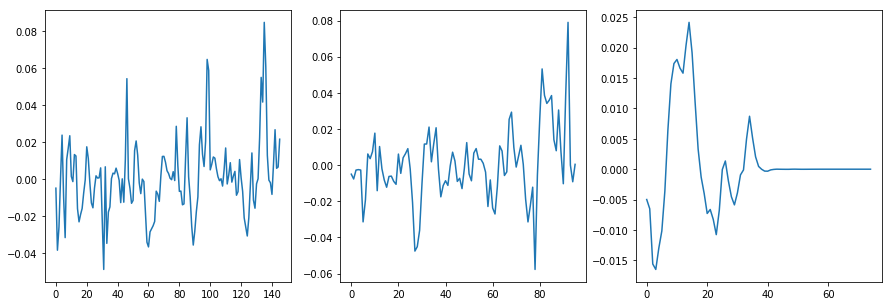

(array([ 0,  0,  0, ..., 47, 47, 47]), array([ 0,  0,  0, ..., 31, 31, 31]), array([ 0,  1,  2, ..., 19, 20, 24]))
(array([  1,   1,   1, ..., 142, 142, 142]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  4,  7, ..., 58, 61, 73]))
X_train shape (19274, 3, 3, 3, 3)
tau_train shape (19274, 1)
19274 train samples
19126 test samples
[[[[ 0.61426491  0.35302837 -0.41810399]
   [ 0.63530057  0.32613819 -0.48255006]
   [ 0.69430854  0.25236689 -0.46693251]]

  [[ 0.54050032  0.44776002 -0.32149436]
   [ 0.65867096  0.36912319 -0.37691685]
   [ 0.75268294  0.26500278 -0.38409385]]

  [[ 0.53731525  0.53868469 -0.1417047 ]
   [ 0.66804776  0.40233094 -0.20600922]
   [ 0.77644325  0.21961518 -0.23954947]]]


 [[[ 0.84110821  0.2908414  -0.32452353]
   [ 0.69259681  0.39467179 -0.40963549]
   [ 0.63953217  0.38615346 -0.45110959]]

  [[ 0.69071963  0.42876177 -0.37473444]
   [ 0.72625037  0.42101089 -0.46275574]
   [ 0.79548243  0.31621869 -0.46983991]]

  [[ 0.69103147  0.57650866 -0.161530

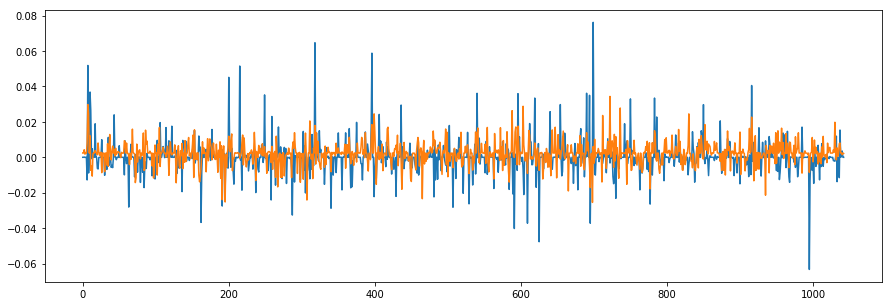

In [487]:
model = main('conv-3d NN')